In [183]:
import pandas as pd
import numpy as np
import multiprocessing
import math
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score


In [184]:
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Torch version: 2.5.1+cu121
CUDA version: 12.1
GPU available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Device: cuda


In [185]:
def check_data_quality(X, y, target_cols):
    print('------------------ Checking Shapes -----------------------------')
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    print('------------------ Checking Datatypes -----------------------------')
    print(f"X dtype: {X.dtype}")
    print(f"y dtype: {y.dtype}")

    print('------------------ Checking Null Values -----------------------------')
    print(f"NaN in X: {torch.isnan(X).sum()}")
    print(f"Inf in X: {torch.isinf(X).sum()}")

    print('------------------ Checking Infinite Values --------------------------')
    print(f"NaN in y: {torch.isnan(y).sum()}")
    print(f"Inf in y: {torch.isinf(y).sum()}")

    print('------------------- Checking Class Distribution ---------------------')
    for i, col in enumerate(target_cols):
        pos_count = (y[:, i] == 1).sum().item()
        total = len(y)
        print(f"{col}: {pos_count} out of {total}")
        print(f"Positive Count Percent : ({pos_count/total*100:.2f}%)")
        print('\n')  

In [186]:
def check_model_weights(model):
    print('-------------------- Model Weight Diagnostic ------------------------')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} : mean = {param.data.mean(): .6f}")
            print(f"{name} : std = {param.data.std(): .6f}")

            if param.grad is not None:
                grad_norm = param.grad.data.norm()
                print(f"->  grad norm : {grad_norm: .6f}")
            else:
                print("-> grad none")

In [187]:
def debug_train_step(model, train_loader, optimizer, criterion, device, num_batches = 3):
    model.train()
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        if i >= num_batches:
            break

        print("------------------------ Training Step --------------------------")
        x_batch_debug, y_batch_debug = x_batch.to(device), y_batch.to(device)

        print("------------------ Forward Pass Diagnostic ---------------------")
        print(f"Input batch shape: {x_batch_debug.shape}")
        print(f"Target batch shape: {y_batch_debug.shape}")

        with torch.no_grad():
            if hasattr(model, 'embedding'):
                embedded = model.embedding(x_batch_debug)
                print(f"Embedded shape: {embedded.shape}")
                print(f"Embedded mean: {embedded.mean().item():.6f}, std: {embedded.std().item():.6f}")

            logits = model(x_batch_debug)
            print(f"Logits Shape : {logits.shape}")
            print(f"Logits mean: {logits.mean().item():.6f}, std: {logits.std().item():.6f}")
            print(f"Logits range: [{logits.min().item():.6f}, {logits.max().item():.6f}]")

            if torch.isnan(logits).any():
                print('Warning logits -> nan')
            elif torch.isinf(logits).any():
                print('Warning logits tending -> inf')

            if logits.ndim > 1 and logits.shape[1] > 1:
                probs = torch.sigmoid(logits)
            else:
                probs = torch.sigmoid(logits)

            print(f"Probs mean: {probs.mean().item():.6f}, std: {probs.std().item():.6f}")
            print(f"Probs range: [{probs.min().item():.6f}, {probs.max().item():.6f}]")

            if probs.std().item() < 1e-6:
                print("⚠️ WARNING: Probabilities have very low variance. The model might be stuck or the learning rate is too small.")

        print("----------------------------------------------------------------")

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        weight_before = {
            name : param.data.clone() for name, param in model.named_parameters()
            }
        
        optimizer.zero_grad()

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        print(f"loss : {loss.item():.6f}")

        if torch.isnan(loss).any():
                print('Warning loss -> nan')
        elif torch.isinf(loss).any():
                print('Warning loss tending -> inf')

        loss.backward()

        print("-------------------- gradient diagnostic -------------------")

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0)
        print(f"Total gradient norm (after clipping): {total_norm:.6f}")

        if total_norm < 1e-7:
            print("⚠️ WARNING: Very small gradients - model might not learn!")

        optimizer.step()

        for name, param in model.named_parameters():
            diff = (param.data - weight_before[name]).abs().max().item()
            print(f"Max Weight Change in {name} : {diff:.8f}")
            if diff < 1e-8:
                print(f"weights are not changing {name}")
    
    return True

In [188]:
def debug_forward_pass(model, X_batch, y_batch, device):
    print('---------------------- Forward Pass Fix -----------------------------')

    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    original_mode = model.training         # Temporal Switch
    model.eval() 

    with torch.no_grad():
        print('-------------------- Batch Sizes --------------------------------')
        print(f"Input batch shape: {X_batch.shape}")
        print(f"Target batch shape: {y_batch.shape}")

        if hasattr(model, 'embedding'):
            embedded = model.embedding(X_batch)
            print(f"Embedded shape: {embedded.shape}")
            print(f"Embedded mean: {embedded.mean().item():.6f}, std: {embedded.std().item():.6f}")

        try:
            logits = model(X_batch)
            print(f"Logits Shape : {logits.shape}")
            print(f"Logits mean: {logits.mean().item():.6f}, std: {logits.std().item():.6f}")
            print(f"Logits range: [{logits.min().item():.6f}, {logits.max().item():.6f}]")

            if torch.isnan(logits).any():
                print('Warning logits -> nan')
            elif torch.isinf(logits).any():
                print('Warning logits tending -> inf')

            if logits.ndim > 1 and logits.shape[1] > 1:
                probs = torch.sigmoid(logits)
            else:
                probs = torch.sigmoid(logits)

            print(f"Probs mean: {probs.mean().item():.6f}, std: {probs.std().item():.6f}")
            print(f"Probs range: [{probs.min().item():.6f}, {probs.max().item():.6f}]")

            if probs.std().item() < 1e-6:
                print("⚠️ WARNING: Probabilities have very low variance. The model might be stuck or the learning rate is too small.")

        except RuntimeError as e:
            print(f"ERROR during Forward Pass {e}")

    model.train(original_mode)

In [189]:
class WeightClass(nn.Module):
    def _init_weights(self, name):
        if name == 'lstm':
            for name, param in self.named_parameters():
                if 'lstm.weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'lstm.weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'lstm.bias_ih' in name or 'lstm.bias_hh' in name:
                    nn.init.zeros_(param)
                    if 'bias_hh' in name:  # Fixed: was 'bias.hh'
                        n = param.size(0)
                        param.data[n//4 : n//2].fill_(1.0)
                elif 'fc' in name and 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'fc' in name and 'bias' in name:
                    nn.init.zeros_(param)
                
        elif name == 'gru':
            for name, param in self.named_parameters():
                if 'gru.weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'gru.weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'gru.bias' in name:
                    nn.init.zeros_(param)
                elif 'fc' in name and 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'fc' in name and 'bias' in name:
                    nn.init.zeros_(param)

        else:
            for name, param in self.named_parameters():
                if 'weight' in name:
                    if 'transformer' in name:
                        if len(param.shape) > 1:
                            nn.init.xavier_uniform_(param)
                    elif 'fc' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'embedding' in name:
                        nn.init.uniform_(param, -0.1, 0.1)
                elif 'bias' in name:
                    nn.init.zeros_(param)

In [190]:
class LSTMClassifier(WeightClass):
    def __init__(self, embedding_layer, hidden_dim, output_dim, num_layers = 1, bidirectional = False, dropout = 0.3):
        super().__init__()
        self.embedding = embedding_layer
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size = embedding_layer.embedding_dim,
                            hidden_size = hidden_dim,
                            num_layers = num_layers,
                            batch_first = True,
                            bidirectional = bidirectional,
                            dropout = dropout if num_layers > 1 else 0)
        
        direction = 2 if bidirectional else 1
        self.layer_norm = nn.LayerNorm(hidden_dim * direction)
        self.fc1 = nn.Linear(hidden_dim * direction, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout_fc = nn.Dropout(0.5)
        self._init_weights('lstm')

    def forward(self, X):
        x = self.embedding(X)
        x = self.dropout(x)
        output, (hidden, cell) = self.lstm(x)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)
        else:
            hidden = hidden[-1, :, :]
    
        hidden = self.layer_norm(hidden)
        hidden = torch.relu(self.fc1(hidden))
        hidden = self.dropout_fc(hidden)
        out = self.fc2(hidden)
        
        return out

In [191]:
class GRUClassifier(WeightClass):
    def __init__(self, embedding_layer, hidden_dim ,output_dim, num_layers = 1, bidirectional = False, dropout = 0.3):
        super().__init__()
        self.embedding = embedding_layer
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(input_size=embedding_layer.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout=dropout if num_layers > 1 else 0)
        
        direction = 2 if bidirectional else 1
        self.ln = nn.LayerNorm(hidden_dim * direction)
        self.fc1 = nn.Linear(hidden_dim * direction, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout_fc = nn.Dropout(0.5)
        self._init_weights('gru')  
        
    def forward(self, X):
        x = self.embedding(X)
        x = self.dropout(x)  
        out, hidden = self.gru(x)

        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        hidden = self.ln(hidden)
        hidden = torch.relu(self.fc1(hidden))
        hidden = self.dropout_fc(hidden)
        out = self.fc2(hidden)

        return out

In [192]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(1, max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [193]:
class TransformerClassifier(WeightClass):  # Fixed: was TransformerClassifer
    def __init__(self, embedding_layer, nhead, nhid, nlayers, output_dim, dropout=0.1):
        super().__init__()
        self.embedding = embedding_layer
        self.pos_encoder = PositionalEncoding(embedding_layer.embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_layer.embedding_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers= nlayers)
        self.fc = nn.Linear(embedding_layer.embedding_dim, output_dim)
        self._init_weights('transformer')  

    def forward(self, src):
        src = self.embedding(src)
        src_pos = self.pos_encoder(src)
        output = self.transformer_encoder(src_pos)
        output = output.mean(dim = 1)
        out = self.fc(output)
        return out

In [194]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, pos_weight = None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, pos_weight = self.pos_weight, reduction = 'none')
        pt = p*targets + (1-p)*(1-targets)
        loss = ce_loss * ((1-pt)**self.gamma)

        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1-self.alpha)*(1-targets)
            loss = alpha_t*loss

        return loss.mean()

In [195]:
class DepressionDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.tensor(y.values, dtype = torch.float32)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [196]:
def tokens_to_indices(tokens, word_to_idx, PAD_IDX=0, OOV_IDX=1):
    idxs = [word_to_idx.get(token, OOV_IDX) for token in tokens]
    return torch.tensor(idxs, dtype=torch.long)

In [197]:
def pad_to_len(sequences, max_len, pad_value):
    return torch.stack([
        torch.cat([s, torch.full((max_len - len(s),), pad_value, dtype=torch.long)]) 
        if len(s) < max_len else s[:max_len]
        for s in sequences
    ])

In [198]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, patience=7, debug_mode=False):
    best_val_loss = float('inf')
    patience_counter = 0  # Fixed: was patience_count

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        if debug_mode and epoch == 0:
            print(f"-------------------- DEBUG MODE ----------------------------")
            success = debug_train_step(model, train_loader, optimizer, criterion, device, num_batches=2)
            if not success:
                print('model failed at debug step')
                return False
            print('subsequent epochs')

        print(f"----------------------- TRAIN MODE -----------------------------")
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss).any():
                print('Warning loss -> nan')
            elif torch.isinf(loss).any():
                print('Warning loss tending -> inf')
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = total_loss / num_batches
        model.eval()
        val_loss = 0
        val_batches = 0 
        all_probs = []

        print(f"------------------------ EVAL MODE -----------------------------")
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_batches += 1
                if outputs.ndim > 1 and outputs.shape[1] > 1:
                    probs = torch.sigmoid(outputs)
                else:
                    probs = torch.sigmoid(outputs)
                all_probs.append(probs.cpu().numpy())

        avg_val_loss = val_loss / val_batches
        if all_probs:
            all_probs = np.vstack(all_probs)
            prob_mean = all_probs.mean()
            prob_std = all_probs.std()
        else:
            prob_mean, prob_std = 0, 0

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"  Prob stats: mean={prob_mean:.4f}, std={prob_std:.4f}")
        
        if prob_std < 0.01:
            print("  WARNING: Model predictions have very low variance! Model might be stuck or underfitting.")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("  ✓ New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
                break
    
    return True

In [199]:
def find_best_thresholds(model, val_loader, device, num_labels, target_cols):  
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y_batch.numpy())
    
    all_probs = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)

    print("----------------------- Threshold Optimization --------------------")
    print("Predicted Probs stats per label")
    for i in range(num_labels):
        print(f"{target_cols[i]}: min={all_probs[:, i].min():.4f}, "
              f"max={all_probs[:, i].max():.4f}, mean={all_probs[:, i].mean():.4f}, "
              f"std={all_probs[:, i].std():.4f}")

    best_thresholds = {}
    print("----------------------- Balanced Threshold Optimization --------------------")
    for i in range(num_labels):
        y_true = all_targets[:, i]
        y_prob = all_probs[:, i]

        precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
        best_thresh, best_f1 = 0.5, 0.0
        chosen_p, chosen_r = 0.0, 0.0

        for p, r, t in zip(precisions, recalls, np.append(thresholds, 1.0)):
            if p >= 0.75 and r >= 0.75:  
                f1 = 2 * p * r / (p + r + 1e-9)
                if f1 > best_f1:
                    best_f1, best_thresh = f1, t
                    chosen_p, chosen_r = p, r

        if chosen_p < 0.75 or chosen_r < 0.75:
            f1s = 2 * precisions * recalls / (precisions + recalls + 1e-9)
            idx = np.argmax(f1s)
            best_thresh = thresholds[idx]
            chosen_p, chosen_r = precisions[idx], recalls[idx]

        best_thresholds[i] = best_thresh
        print(f"{target_cols[i]} : Threshold = {best_thresh:.2f}, Precision = {chosen_p:.2f}, Recall = {chosen_r:.2f}")

    return best_thresholds


In [200]:
def evaluate_and_plot_roc(model, dataloader, device, target_cols, thresholds):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            
            all_preds.append(preds)
            all_labels.append(y_batch.numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    if isinstance(thresholds, dict):
        thresholds_list = [thresholds[i] for i in range(len(target_cols))]
    elif isinstance(thresholds, (float, int)):
        thresholds_list = [thresholds] * len(target_cols)
    else:
        thresholds_list = thresholds

    all_preds_bin = np.zeros_like(all_preds, dtype=int)
    for i, thresh in enumerate(thresholds_list):
        all_preds_bin[:, i] = (all_preds[:, i] >= thresh).astype(int)

    num_labels = len(target_cols)
    rows = math.ceil(num_labels / 3)
    cols = min(num_labels, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    if num_labels == 1:
        axes = [axes]
    elif num_labels > 1:
        axes = axes.flatten()

    for i, col in enumerate(target_cols):
        if np.sum(all_labels[:, i]) > 0 and np.sum(all_labels[:, i] == 0) > 0:
            cm = confusion_matrix(all_labels[:, i], all_preds_bin[:, i])
        else:
            cm = np.zeros((2, 2)) 
            if np.sum(all_labels[:, i]) == 0: cm[0,0] = len(all_labels)
            else: cm[1,1] = len(all_labels)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["True 0", "True 1"],
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {col}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    for i, col in enumerate(target_cols):
        if np.sum(all_labels[:, i]) > 0 and np.sum(all_labels[:, i] == 0) > 0:
            fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
            auc_score = roc_auc_score(all_labels[:, i], all_preds[:, i])
            plt.plot(fpr, tpr, label=f'{col} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves per Label')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [201]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [202]:
print("Loading data...")
train_df = pd.read_csv('F:/Projects/Machine and Deep Learning/Depression_Severity/Datasets/train_lemma.csv')
train_df

Loading data...


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lemmas
0,0000997932d777bf,explanationwhy the edits made under my usernam...,0,0,0,0,0,0,"['explanationwhy', 'the', 'edit', 'make', 'und..."
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[""d'aww"", 'he', 'match', 'this', 'background',..."
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,"['hey', 'man', 'I', 'be', 'really', 'not', 'tr..."
3,0001b41b1c6bb37e,morei can't make any real suggestions on impro...,0,0,0,0,0,0,"['morei', 'can', 'not', 'make', 'any', 'real',..."
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,"['you', 'sir', 'be', 'my', 'hero', 'any', 'cha..."
...,...,...,...,...,...,...,...,...,...
137136,ffe987279560d7ff,"and for the second time of asking, when your v...",0,0,0,0,0,0,"['and', 'for', 'the', 'second', 'time', 'of', ..."
137137,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0,"['you', 'should', 'be', 'ashamed', 'of', 'your..."
137138,ffee36eab5c267c9,"spitzer umm, theres no actual article for pros...",0,0,0,0,0,0,"['spitzer', 'umm', 'there', 's', 'no', 'actual..."
137139,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0,"['and', 'it', 'look', 'like', 'it', 'be', 'act..."


In [203]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lemmas'],
      dtype='object')

In [204]:
sentences = [ast.literal_eval(x) for x in train_df['lemmas']]
print(sentences[:5])

[['explanationwhy', 'the', 'edit', 'make', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'be', 'revert', 'they', 'be', 'not', 'vandalism', 'just', 'closure', 'on', 'some', 'gas', 'after', 'I', 'vote', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'do', 'not', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', 'be', 'retire', 'now.89.205.38.27'], ["d'aww", 'he', 'match', 'this', 'background', 'colour', 'I', 'be', 'seemingly', 'stuck', 'with', 'thank', 'talk', '2151', 'january', '11', '2016', 'utc'], ['hey', 'man', 'I', 'be', 'really', 'not', 'try', 'to', 'edit', 'war', 'it', 'be', 'just', 'that', 'this', 'guy', 'be', 'constantly', 'remove', 'relevant', 'information', 'and', 'talk', 'to', 'I', 'through', 'edit', 'instead', 'of', 'my', 'talk', 'page', 'he', 'seem', 'to', 'care', 'more', 'about', 'the', 'formatting', 'than', 'the', 'actual', 'info'], ['morei', 'can', 'not', 'make', 'any', 'real', 'suggestion', 'on', 'improvement', 'I', 'wonder', 

In [205]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train_df[target_cols]
print(y.shape)

(137141, 6)


In [206]:
print("Training Word2Vec...")
# num_cores = multiprocessing.cpu_count()
# embed_cbow = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=0, workers=num_cores)
# embed_skip = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=1, workers=num_cores)
# embed_cbow.save("cbow.model")
# print("Cbow Saved.......")
# embed_skip.save("skipgram.model")
# print("Skipgram Saved.......")

Training Word2Vec...


In [207]:
embed_cbow = Word2Vec.load("cbow.model")
embed_skip = Word2Vec.load("skipgram.model")

In [208]:
PAD_IDX = 0
OOV_IDX = 1

word_to_idx_cbow = {word: i+2 for i, word in enumerate(embed_cbow.wv.index_to_key)}
X_train_sents, X_val_sents, y_train, y_val = train_test_split(
    sentences, y, test_size=0.2, random_state=42
)

X_train_indices = [tokens_to_indices(s, word_to_idx_cbow, PAD_IDX, OOV_IDX) for s in X_train_sents]
X_val_indices = [tokens_to_indices(s, word_to_idx_cbow, PAD_IDX, OOV_IDX) for s in X_val_sents]

lengths = [len(s) for s in X_train_indices + X_val_indices]
max_len = int(np.percentile(lengths, 95))
print(f"Using max_len = {max_len}")

X_train_padded = pad_to_len(X_train_indices, max_len, PAD_IDX)
X_val_padded = pad_to_len(X_val_indices, max_len, PAD_IDX)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

Using max_len = 98


In [209]:
weights_cbow = torch.FloatTensor(embed_cbow.wv.vectors)
padding_vector = torch.zeros((1, weights_cbow.size(1)))
oov_vector = torch.randn((1, weights_cbow.size(1))) * 0.1
weights_with_padding_oov = torch.cat([padding_vector, oov_vector, weights_cbow], dim=0)
embedding_layer = nn.Embedding.from_pretrained(weights_with_padding_oov, freeze=False, padding_idx=PAD_IDX)
print(embedding_layer.embedding_dim) 

100


In [210]:
train_dataset = DepressionDataset(X_train_padded, y_train)
val_dataset = DepressionDataset(X_val_padded, y_val)

In [211]:
check_data_quality(X_train_padded, y_train, target_cols)

------------------ Checking Shapes -----------------------------
X shape: torch.Size([109712, 98])
y shape: torch.Size([109712, 6])
------------------ Checking Datatypes -----------------------------
X dtype: torch.int64
y dtype: torch.float32
------------------ Checking Null Values -----------------------------
NaN in X: 0
Inf in X: 0
------------------ Checking Infinite Values --------------------------
NaN in y: 0
Inf in y: 0
------------------- Checking Class Distribution ---------------------
toxic: 11273 out of 109712
Positive Count Percent : (10.28%)


severe_toxic: 1116 out of 109712
Positive Count Percent : (1.02%)


obscene: 6221 out of 109712
Positive Count Percent : (5.67%)


threat: 353 out of 109712
Positive Count Percent : (0.32%)


insult: 5846 out of 109712
Positive Count Percent : (5.33%)


identity_hate: 1014 out of 109712
Positive Count Percent : (0.92%)




In [212]:
check_data_quality(X_val_padded, y_val, target_cols)

------------------ Checking Shapes -----------------------------
X shape: torch.Size([27429, 98])
y shape: torch.Size([27429, 6])
------------------ Checking Datatypes -----------------------------
X dtype: torch.int64
y dtype: torch.float32
------------------ Checking Null Values -----------------------------
NaN in X: 0
Inf in X: 0
------------------ Checking Infinite Values --------------------------
NaN in y: 0
Inf in y: 0
------------------- Checking Class Distribution ---------------------
toxic: 2811 out of 27429
Positive Count Percent : (10.25%)


severe_toxic: 304 out of 27429
Positive Count Percent : (1.11%)


obscene: 1607 out of 27429
Positive Count Percent : (5.86%)


threat: 97 out of 27429
Positive Count Percent : (0.35%)


insult: 1508 out of 27429
Positive Count Percent : (5.50%)


identity_hate: 275 out of 27429
Positive Count Percent : (1.00%)




In [213]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [214]:
num_negatives = (y_train == 0).sum(dim=0).float()
num_positives = (y_train == 1).sum(dim=0).float()

pos_weight = torch.log1p(num_negatives / (num_positives + 1e-6))
pos_weight = pos_weight.to(device)

print(f"Pos weights: {pos_weight}")


Pos weights: tensor([2.2754, 4.5881, 2.8699, 5.7391, 2.9321, 4.6840], device='cuda:0')


In [215]:
model_configs = {
    # "BiLSTM": {
    #     "class": LSTMClassifier,
    #     "params": {
    #         "hidden_dim": 256,
    #         "output_dim": 6,  
    #         "bidirectional": True,
    #         "dropout": 0.3
    #     }
    # },
    "BiGRU": {
        "class": GRUClassifier,
        "params": {
            "hidden_dim": 256,
            "output_dim": 6,  
            "bidirectional": True,
            "dropout": 0.3
        }
    }
}

In [216]:
print(type(y_train), y_train.shape)
print(type(y_val), y_val.shape)
print(y_train[:5])
print(y_val[:5])

<class 'torch.Tensor'> torch.Size([109712, 6])
<class 'torch.Tensor'> torch.Size([27429, 6])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


In [217]:
for i, (xb, yb) in enumerate(train_loader):
    if yb is None:
        print("⚠️ y_batch is None here!")
        break

--------------------------------- Training Architecture ------------------------

TRAINING BIGRU MODEL
Model parameters: 6,062,750
Using BCE Loss
Learning rate: 0.0001
Model type: BiGRU
--------------------------------- STARTING BIGRU TRAINING -------------------------------------
----------------------- TRAIN MODE -----------------------------


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


------------------------ EVAL MODE -----------------------------
Epoch [1/10], Train Loss: 0.1775, Val Loss: 0.1192
  Prob stats: mean=0.0652, std=0.1860
  ✓ New best model saved!
----------------------- TRAIN MODE -----------------------------
------------------------ EVAL MODE -----------------------------
Epoch [2/10], Train Loss: 0.1268, Val Loss: 0.1120
  Prob stats: mean=0.0596, std=0.1837
  ✓ New best model saved!
----------------------- TRAIN MODE -----------------------------
------------------------ EVAL MODE -----------------------------
Epoch [3/10], Train Loss: 0.1172, Val Loss: 0.1082
  Prob stats: mean=0.0636, std=0.1938
  ✓ New best model saved!
----------------------- TRAIN MODE -----------------------------
------------------------ EVAL MODE -----------------------------
Epoch [4/10], Train Loss: 0.1087, Val Loss: 0.1045
  Prob stats: mean=0.0611, std=0.1938
  ✓ New best model saved!
----------------------- TRAIN MODE -----------------------------
--------------------

C:\Users\ketan\AppData\Local\Temp\ipykernel_7516\1483217427.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


----------------------- Threshold Optimization --------------------
Predicted Probs stats per label
toxic: min=0.0000, max=1.0000, mean=0.1270, std=0.2829
severe_toxic: min=0.0000, max=0.9476, mean=0.0231, std=0.1147
obscene: min=0.0000, max=0.9996, mean=0.0739, std=0.2290
threat: min=0.0000, max=0.9741, mean=0.0092, std=0.0673
insult: min=0.0000, max=0.9958, mean=0.0787, std=0.2248
identity_hate: min=0.0000, max=0.9005, mean=0.0208, std=0.0909
----------------------- Balanced Threshold Optimization --------------------
toxic : Threshold = 0.68, Precision = 0.84, Recall = 0.77
severe_toxic : Threshold = 0.62, Precision = 0.43, Recall = 0.61
obscene : Threshold = 0.72, Precision = 0.84, Recall = 0.81
threat : Threshold = 0.71, Precision = 0.52, Recall = 0.55
insult : Threshold = 0.58, Precision = 0.69, Recall = 0.84
identity_hate : Threshold = 0.52, Precision = 0.44, Recall = 0.54

BIGRU Per-Class Performance:
----------------------------------------------------------------------
Class 

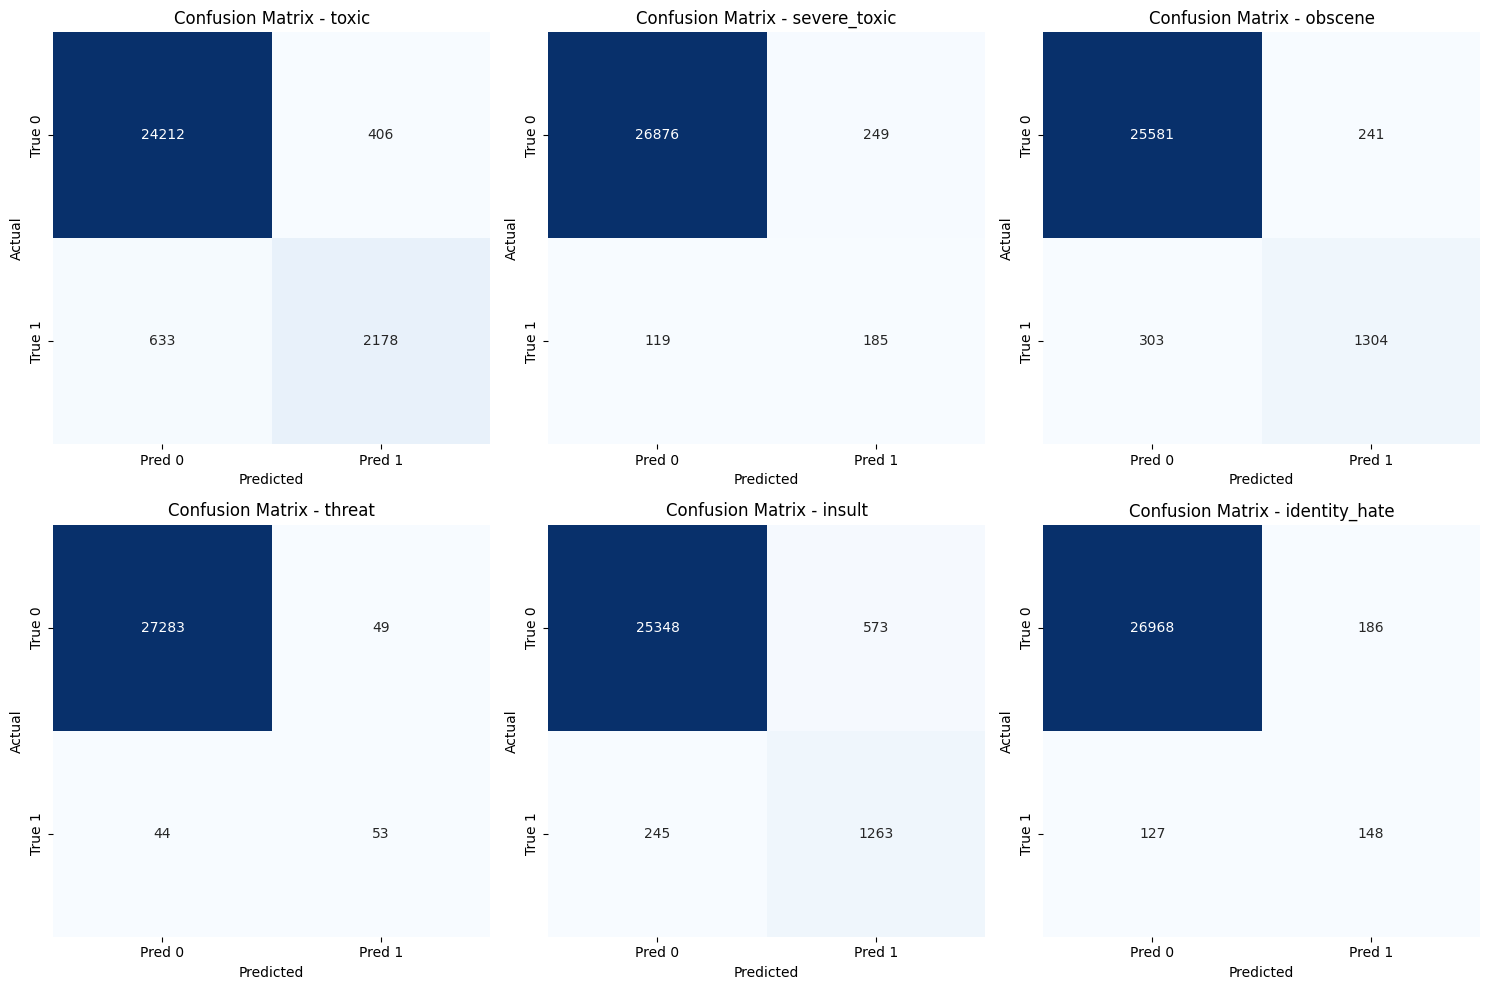

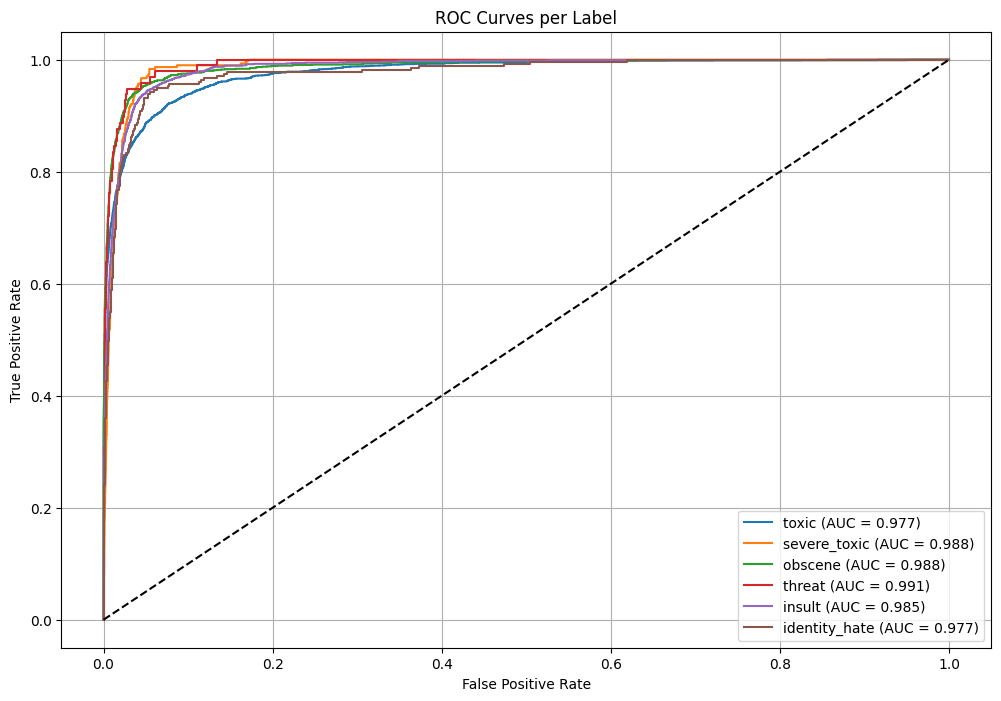


✅ BIGRU TRAINING AND EVALUATION COMPLETE!
----------------------------------------------------------


In [218]:
print("--------------------------------- Training Architecture ------------------------")
model_results = {}
all_training_results = []

for model_type, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"TRAINING {model_type.upper()} MODEL")
    print(f"{'='*60}")

    model = config["class"](embedding_layer, **config["params"]).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    use_focal_loss = False  

    if use_focal_loss:
        criterion = FocalLoss(alpha=0.1, gamma=3.0, pos_weight=pos_weight)
        print("Using Focal Loss")
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print("Using BCE Loss")

    learning_rate = 1e-4  
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    print(f"Learning rate: {learning_rate}")
    print(f"Model type: {model_type}")
    print(f"--------------------------------- STARTING {model_type.upper()} TRAINING -------------------------------------")

    num_epochs = 10
    success = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, 
        num_epochs=num_epochs, patience=5, debug_mode=(model_type == "BiLSTM")
    )

    if not success:
        print(f"❌ {model_type} training failed! Check the output above.")
        model_results[model_type] = None
        continue

    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print(f"✅ Loaded best {model_type} model for evaluation")
    except:
        print(f"⚠️ Could not load best {model_type} model, using current weights")

    print(f"\n{'='*50}")
    print(f"{model_type.upper()} EVALUATION")
    print("="*50)

    best_thresholds = find_best_thresholds(model, val_loader, device, len(target_cols), target_cols)

    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            if y_batch is None:
                raise ValueError("y_batch is None! Check your dataset.")
            logits = model(X_batch)
            if logits is None:
                raise ValueError("Model output is None! Check your forward pass.")

            # Ensure shape consistency
            if logits.ndim == 2 and logits.shape[1] == 1:
                y_batch = y_batch.view(-1, 1)

            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)

    # Per-class metrics
    class_results = {}
    print(f"\n{model_type.upper()} Per-Class Performance:")
    print("-" * 70)
    print(f"{'Class':<20} | {'Threshold':<9} | {'F1':<6} | {'Precision':<9} | {'Recall':<6} | {'AUC':<6}")
    print("-" * 70)

    for i, class_name in enumerate(target_cols):
        y_true = all_labels[:, i]
        y_prob = all_probs[:, i]
        threshold = best_thresholds[i]

        y_pred = (y_prob >= threshold).astype(int)

        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)

        try:
            auc = roc_auc_score(y_true, y_prob)
        except:
            auc = 0.0

        class_results[class_name] = {
            'threshold': threshold,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'auc': auc
        }

        print(f"{class_name:<20} | {threshold:<9.3f} | {f1:<6.3f} | {precision:<9.3f} | {recall:<6.3f} | {auc:<6.3f}")

    # Average metrics
    avg_f1 = np.mean([class_results[col]['f1'] for col in target_cols])
    avg_precision = np.mean([class_results[col]['precision'] for col in target_cols])
    avg_recall = np.mean([class_results[col]['recall'] for col in target_cols])
    avg_auc = np.mean([class_results[col]['auc'] for col in target_cols])

    print("-" * 70)
    print(f"{'AVERAGE':<20} | {'':<9} | {avg_f1:<6.3f} | {avg_precision:<9.3f} | {avg_recall:<6.3f} | {avg_auc:<6.3f}")
    print("-" * 70)

    model_results[model_type] = {
        'model': model,
        'thresholds': best_thresholds,
        'class_results': class_results,
        'averages': {
            'f1': avg_f1,
            'precision': avg_precision,
            'recall': avg_recall,
            'auc': avg_auc
        }
    }

    all_training_results.append({
        'model_name': model_type,
        'avg_f1': avg_f1,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_auc': avg_auc,
        'detailed_results': class_results
    })

    torch.save(model.state_dict(), f'best_model_{model_type.lower()}.pth')
    print(f"💾 Saved {model_type} model as 'best_model_{model_type.lower()}.pth'")

    evaluate_and_plot_roc(model, val_loader, device, target_cols, best_thresholds)

    print(f"\n✅ {model_type.upper()} TRAINING AND EVALUATION COMPLETE!")
    print("----------------------------------------------------------")


In [219]:
print("\n" + "-"*80)
print("🏆 FINAL MODEL COMPARISON RESULTS")
print("-"*80)

if all_training_results:
    print(f"{'Model':<12} | {'Avg F1':<8} | {'Avg Precision':<13} | {'Avg Recall':<11} | {'Avg AUC':<8} | {'Status':<8}")
    print("-" * 75)
    
    for result in all_training_results:
        status = "✅ Good" if result['avg_f1'] > 0.1 else "⚠️ Poor"
        print(f"{result['model_name']:<12} | {result['avg_f1']:<8.4f} | {result['avg_precision']:<13.4f} | "
              f"{result['avg_recall']:<11.4f} | {result['avg_auc']:<8.4f} | {status}")
    
    print("-" * 75)
    
    best_f1_model = max(all_training_results, key=lambda x: x['avg_f1'])
    best_auc_model = max(all_training_results, key=lambda x: x['avg_auc'])
    
    print(f"\n🥇 BEST F1 SCORE: {best_f1_model['model_name']} ({best_f1_model['avg_f1']:.4f})")
    print(f"🥇 BEST AUC SCORE: {best_auc_model['model_name']} ({best_auc_model['avg_auc']:.4f})")
    
    # Recommendation
    print("\n" + "="*60)
    print("📊 RECOMMENDATION")
    print("="*60)
    
    if best_f1_model['avg_f1'] < 0.3:
        print("⚠️ WARNING: All models show poor performance (F1 < 0.3)")
        print("Consider:")
        print("- Checking data quality and preprocessing")
        print("- Adjusting hyperparameters")
        print("- Using different architectures or techniques")
        print("- Collecting more/better training data")
    else:
        print(f"🎯 RECOMMENDED MODEL: {best_f1_model['model_name']}")
        print(f"   • Best overall F1 score: {best_f1_model['avg_f1']:.4f}")
        print(f"   • Average Precision: {best_f1_model['avg_precision']:.4f}")
        print(f"   • Average Recall: {best_f1_model['avg_recall']:.4f}")
        print(f"   • Average AUC: {best_f1_model['avg_auc']:.4f}")
        
        if best_f1_model['model_name'] != best_auc_model['model_name']:
            print(f"\n🎯 ALTERNATIVE: {best_auc_model['model_name']} (Best AUC: {best_auc_model['avg_auc']:.4f})")
            print("   Consider this if you prioritize ranking/probability calibration over classification accuracy")
    
    # Detailed performance breakdown
    print(f"\n📈 DETAILED BREAKDOWN FOR RECOMMENDED MODEL ({best_f1_model['model_name']}):")
    print("-" * 60)
    detailed = best_f1_model['detailed_results']
    for class_name in target_cols:
        metrics = detailed[class_name]
        print(f"{class_name:<25}: F1={metrics['f1']:.3f}, AUC={metrics['auc']:.3f}")
    
    print("\n" + "="*80)
    print("🎉 ALL MODEL TRAINING AND EVALUATION COMPLETE!")
    print("="*80)

else:
    print("❌ No models were successfully trained!")
    print("Please check the debug output and fix any issues.")


--------------------------------------------------------------------------------
🏆 FINAL MODEL COMPARISON RESULTS
--------------------------------------------------------------------------------
Model        | Avg F1   | Avg Precision | Avg Recall  | Avg AUC  | Status  
---------------------------------------------------------------------------
BiGRU        | 0.6517   | 0.6273        | 0.6862      | 0.9843   | ✅ Good
---------------------------------------------------------------------------

🥇 BEST F1 SCORE: BiGRU (0.6517)
🥇 BEST AUC SCORE: BiGRU (0.9843)

📊 RECOMMENDATION
🎯 RECOMMENDED MODEL: BiGRU
   • Best overall F1 score: 0.6517
   • Average Precision: 0.6273
   • Average Recall: 0.6862
   • Average AUC: 0.9843

📈 DETAILED BREAKDOWN FOR RECOMMENDED MODEL (BiGRU):
------------------------------------------------------------
toxic                    : F1=0.807, AUC=0.977
severe_toxic             : F1=0.501, AUC=0.988
obscene                  : F1=0.827, AUC=0.988
threat           